### Explore Data Formats 

In [1]:
import sys
import numpy as np
import os
from tqdm.notebook import tqdm

import chess
import chess.pgn
from chess.pgn import Game, StringExporter
from chess import Board, Move, Piece, Square

from pprint import pprint
from typing import Tuple, Optional

from IPython.display import display, clear_output
from time import sleep

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### The `Board` class
- FEN notation for constructor
- Tracks moves with a stack of `Move` objects
- Supports parsing from SAN

Starting position (FEN Notation) rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR


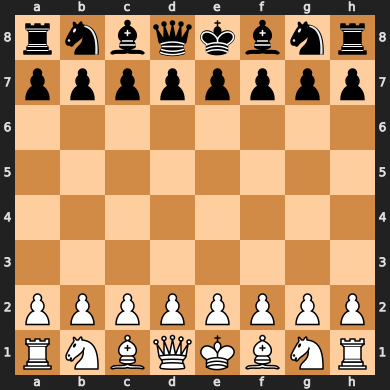

In [2]:
print("Starting position (FEN Notation)", chess.STARTING_BOARD_FEN)
board = Board()
board

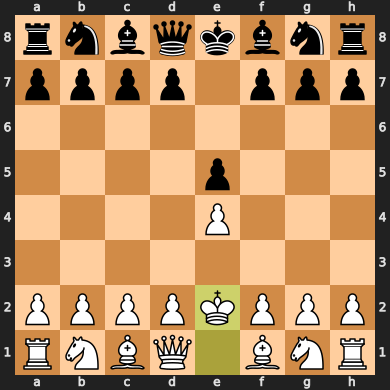

In [3]:
# can add moves this way...
board.push(Move.from_uci("e2e4"))

# OR, in SAN (requires board state, so can't use `Move` interface)
board.push_uci("e7e5")
board.push_uci("e1e2")
board

In [4]:
board.has_castling_rights(chess.WHITE)

False

In [5]:
chess.Color()

False

### The PGN Game interface

- write/parse from PGN.
- e.g) this is basically SAN + headers? 
- support for variations (i.e. alternative game histories, branching off from the tree with arbitary depth?)
- game is represented as a tree

In [6]:
# constructing from our `Board` (can also read from SAN file)
game = Game.from_board(board)

# writing out to PGN (optionally with/without headers)
exporter = chess.pgn.StringExporter(headers=False, variations=False, comments=False)
pgn_string = game.accept(exporter)
print(pgn_string)

1. e4 e5 2. Ke2 *


### Reading Lichess Data

In [39]:
import io
max_games = 10000
game_strings = []
q = ""
with open('../data/lichess_db_standard_rated_2014-01.pgn') as f, \
    tqdm(total=max_games or 700000) as pbar:
    
    i = 0
    n = 0
    while True:
        if max_games is not None and i == max_games:
            break
        line = f.readline()
        if line.strip() == "":
            n += 1
            if n > 0 and (n % 2) == 0:
                game_strings.append(q)
                q = ""
                i += 1
                pbar.update(i)
            else:
                q += line
        else:
            q += line
print(len(game_strings))

  0%|          | 0/10000 [00:00<?, ?it/s]

10000


In [43]:
# parse the games
import io

games = [chess.pgn.read_game(io.StringIO(x)) for x in tqdm(game_strings) ]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
# note: can get headers like this...
# will need to clean data based on this
# - what time controls ?
# - what termination reason ?
# - do we have ELO scores ?
# - minimum game length ? (i.e. 2 moves?)
# - any other signs of corruption / illegal moves? (e.g. failure for `chess` library to parse ?)
pprint(game.headers)

Headers(Event='Rated Bullet game', Site='https://lichess.org/yd5d4l9a', Date='????.??.??', Round='?', White='claudiomat', Black='MisterBiggStuff', Result='0-1', BlackElo='2035', BlackRatingDiff='+3', ECO='A43', Opening='Old Benoni Defense', Termination='Time forfeit', TimeControl='60+0', UTCDate='2013.12.31', UTCTime='23:00:14', WhiteElo='1711', WhiteRatingDiff='-4')


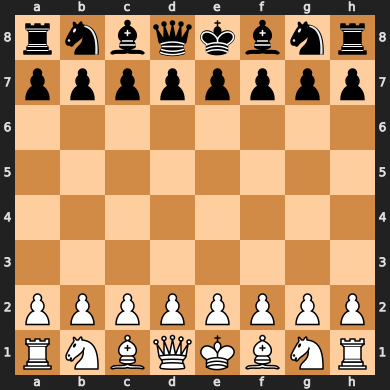

In [10]:
# example of GameNode traversal
node = game
display(node.board())
while True:
    node = node.next()
    if node is None:
        break
    board = node.board()
#     clear_output(wait=True)
#     sleep(0.5)
#     display(board)

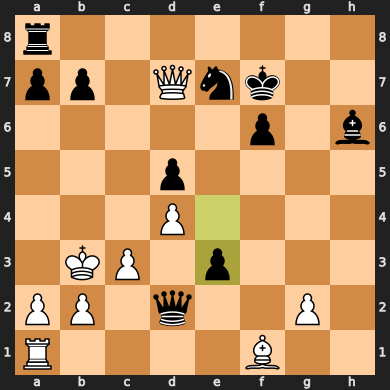

In [11]:
game.end().board()

In [12]:
dir(game)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_interactive_viewer',
 'accept',
 'accept_subgame',
 'add_line',
 'add_main_variation',
 'add_variation',
 'arrows',
 'board',
 'builder',
 'clock',
 'comment',
 'demote',
 'end',
 'errors',
 'eval',
 'eval_depth',
 'from_board',
 'game',
 'has_variation',
 'headers',
 'is_end',
 'is_main_variation',
 'is_mainline',
 'mainline',
 'mainline_moves',
 'move',
 'nags',
 'next',
 'parent',
 'ply',
 'promote',
 'promote_to_main',
 'remove_variation',
 'root',
 'set_arrows',
 'set_clock',
 'set_eval',
 'setup',
 'starting_co

['d2d4', 'c7c5', 'e2e3', 'c5d4', 'e3d4', 'd7d5', 'c2c3', 'b8c6', 'f2f4', 'e7e5', 'g1f3', 'e5e4', 'f3e5', 'f7f6', 'd1h5', 'g7g6', 'e5g6', 'h7g6', 'h5h8', 'e8f7', 'h8h7', 'f8g7', 'f4f5', 'g6g5', 'h2h4', 'g5h4', 'c1h6', 'd8f8', 'h1h4', 'g8h6', 'h4h6', 'c6e7', 'h6h3', 'c8f5', 'h7h4', 'f5h3', 'h4h3', 'f8h8', 'h3d7', 'h8h4', 'e1d2', 'g7h6', 'd2c2', 'h4f2', 'b1d2', 'f2d2', 'c2b3', 'e4e3']


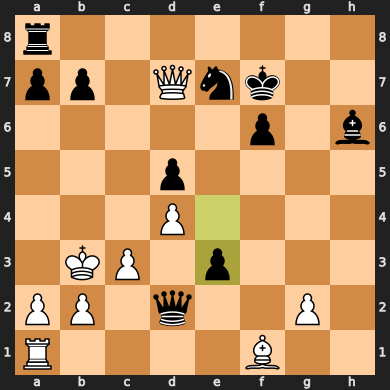

In [13]:
# get the game as a list of UCI moves
board = game.end().board()
uci_moves = [x.uci() for x in board.move_stack]
print(uci_moves)

# ... and back
board = Board()
for move in uci_moves:
    board.push_uci(move)
board

## Representation

AlphaZero uses a spatial encoding and feeds into 2D CNN.   
However, since we have long-range interactions in chess (and for the sake of simplicity), we can just use a flattened representation.  
(DeepMind mention that this works as well). 

### The State of the Board

- Use a flattened array to represent the board (8x8=64 positions).
- Each position is a vector with an embedding of the kind of piece
- Positional embeddings to disambiguate the different board positions.
- e.g) Can process with transformer mapping from (batch, 64, embedding_dim) -> (policy, value)

In [14]:
# ASCII board representation
# 12 piece types + empty square
black_pieces = ['k', 'q', 'b', 'n', 'r', 'p']
white_pieces = [x.upper() for x in black_pieces]
all_pieces = white_pieces + black_pieces + ["."]
int_to_piece = {i:v for i, v in enumerate(all_pieces)}
piece_to_int = {v:k for k, v in int_to_piece.items()}

pprint(int_to_piece)

{0: 'K',
 1: 'Q',
 2: 'B',
 3: 'N',
 4: 'R',
 5: 'P',
 6: 'k',
 7: 'q',
 8: 'b',
 9: 'n',
 10: 'r',
 11: 'p',
 12: '.'}


In [15]:
# Take a `Board` class and represent it as an integer array, indicating
# the piece value of each square. Additionally return a boolean indiciating if 
# white is moving next.
# Note: There are a few bits of information that cannot be derived from this state,
# which require extra consideration.
# - is en-passant available on the next turn?
# - is castling still permitted?
# - what is the move count?
def board_to_flat_repr(board: Board) -> Tuple[np.ndarray, bool]:
    str_repr = f"{board}"
    rank = 0 # rank `1`
    out = []
    for line in str_repr.split("\n")[::-1]:
        pieces = line.strip().split(" ")
        file = 0 # file `a`
        for piece in pieces:
            int_repr = piece_to_int[piece]
            out.append(int_repr)
            file += 1
        rank +=1
    
    return np.array(out), board.turn

## Note: board is flattened (8x8) i.e)
# - first 8 entries = rank 1, a-h
# - next 8 entries = rank 2, a-h
print(board)
flat_repr, white_to_move = board_to_flat_repr(board)
print(flat_repr.reshape(8, 8))

r . . . . . . .
p p . Q n k . .
. . . . . p . b
. . . p . . . .
. . . P . . . .
. K P . p . . .
P P . q . . P .
R . . . . B . .
[[ 4 12 12 12 12  2 12 12]
 [ 5  5 12  7 12 12  5 12]
 [12  0  5 12 11 12 12 12]
 [12 12 12  5 12 12 12 12]
 [12 12 12 11 12 12 12 12]
 [12 12 12 12 12 11 12  8]
 [11 11 12  1  9  6 12 12]
 [10 12 12 12 12 12 12 12]]


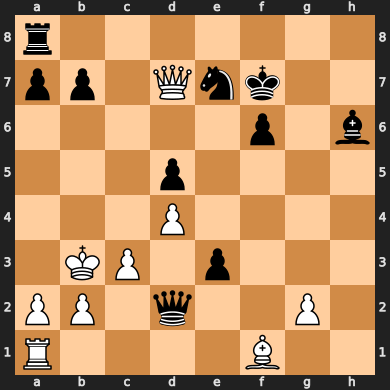

In [16]:
def flat_repr_to_board(flat_repr: np.ndarray, white_to_move: bool) -> Board:
    board = Board()
    board.turn = white_to_move
    for rank_no, rank in enumerate(flat_repr.reshape(8, 8)):
        for file_no, piece in enumerate(rank):
            symbol = int_to_piece[piece]
            piece = None if symbol == "." else Piece.from_symbol(symbol)
            square = chess.square(file_index=file_no, rank_index=rank_no)
            board.set_piece_at(square, piece)
    return board

board = flat_repr_to_board(flat_repr, white_to_move)
board

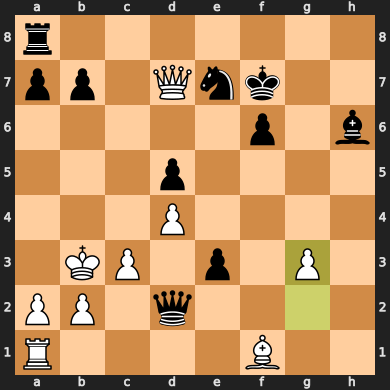

In [17]:
# test that we can continue play on the reconstructed board
# note: the move history has been lost!
board.push_san("g3")
board

### The Distribution over Actions

- 64 starting positions x 64 ending positions = 4096 possible moves
- Only a subset of these are legal (i.e. approx. 30 on average at each step)
- Can use `chess.Board.legal_moves()` to mask the unnormalised logits
- For castling, we just encode the movement of the king (rook movement is implied when king moves 2 steps)
- Note: For pawn promotions, the *kind* of promotion will not be encoded
- However, for the purpose of creating a policy we can just do auto-queens

In [18]:
def square_to_rank_and_file(square: Square) -> (int, int):
    """
    Convert a `chess.Square` into the corresponding rank (1->0) and file (a->0)
    :param square:
    :return:
    """
    return chess.square_rank(square), chess.square_file(square)

def move_to_one_hot(move: Move) -> np.ndarray:
    """
    Convert a `chess.Move` into a one-hot representation, with the following layout:
    (start_rank, start_file, end_rank, end_file) = (8, 8, 8, 8) -> (4096)
    :param move: 
    :return:
    """
    out = np.zeros((8, 8, 8, 8), dtype=np.int64)
    start_rank, start_file = square_to_rank_and_file(move.from_square)
    end_rank, end_file = square_to_rank_and_file(move.to_square)
    out[start_rank, start_file, end_rank, end_file] = 1
    return out.flatten()

def one_hot_to_move(one_hot: np.ndarray) -> Move:
    """
    Convert back from one-hot representation to `chess.Move`
    """
    x = one_hot.reshape((8, 8, 8, 8))
    (i, j, k, l), = zip(*np.where(x))
    start_square = chess.square(rank_index=i, file_index=j)
    end_square = chess.square(rank_index=k, file_index=l)
    return Move(from_square=start_square, to_square=end_square)
    
move = Move.from_uci("e2e4")
one_hot = move_to_one_hot(move)
move_rec = one_hot_to_move(one_hot)
move_rec.uci()

'e2e4'

# Lichess Exploration

In [19]:
games[13].headers

Headers(Event='Rated Classical game', Site='https://lichess.org/h0fgzc2v', Date='????.??.??', Round='?', White='baclayonn', Black='hytrah', Result='1/2-1/2', BlackElo='1027', BlackRatingDiff='+22', ECO='D00', Opening="Queen's Pawn Game", Termination='Normal', TimeControl='1200+5', UTCDate='2013.12.31', UTCTime='23:00:30', WhiteElo='1500', WhiteRatingDiff='-226')

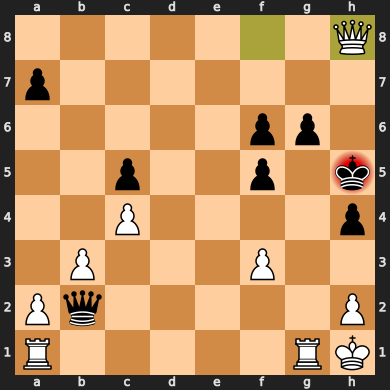

In [20]:
games[4].next().end().board()

In [21]:
time_controls = {}
elos = []
results = []

result_map = {
    "1-0": 0,
    "0-1": 1,
    "1/2-1/2": 2
}

for game in games:
    headers = game.headers
    
    # track elos
    elos += [
        headers['WhiteElo'],
        headers['BlackElo'],
    ]
    
    # track results
    result = result_map[headers['Result']]
    results.append(result)
    
    # track time controls
    tc = headers['TimeControl']
    if tc not in time_controls:
        time_controls[tc] = 0
    time_controls[tc] += 1

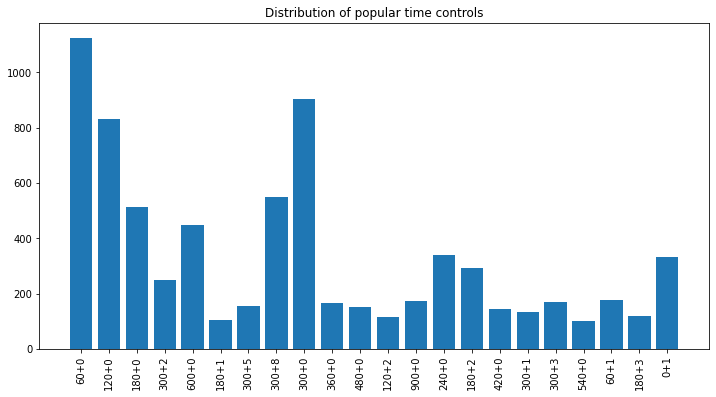

In [22]:
# view time controls
ks, vs = [], []
for k, v in time_controls.items():
    if v < 100:
        continue
    ks.append(k)
    vs.append(v)

plt.figure(figsize=(12, 6))
plt.title("Distribution of popular time controls")
plt.bar(ks, vs)
plt.xticks(rotation=90);
plt.show();

/home/angusturner/miniconda3/envs/py38/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


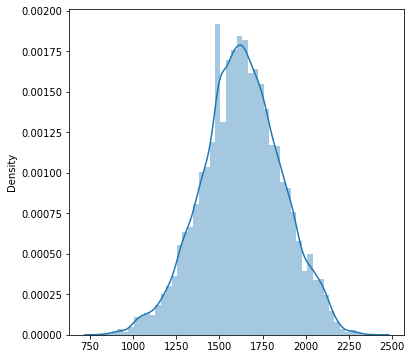

In [23]:
# view the distribution of ELO scores (across all time controls)
plt.figure(figsize=(6, 6))
sns.distplot(elos);

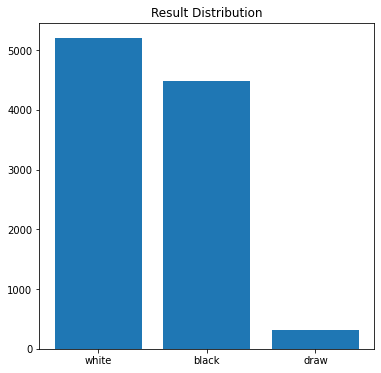

In [24]:
# view the distribution of results! (over all ELOs and time controls)
plt.figure(figsize=(6, 6))
plt.title("Result Distribution")
plt.bar(x=["white", "black", "draw"], height=np.bincount(results))
plt.show();